...

In [1]:
import pandas as pd
import numpy as np
import time
import os
os.chdir('/sfs/qumulo/qhome/bdr6qz/Documents/MSDS/DS6050')

import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pickle

import warnings
warnings.filterwarnings('ignore')

from skopt import BayesSearchCV
from skopt.space import Categorical, Real, Integer
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-04-04 21:58:17.274610: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 21:58:17.325286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 21:58:19.032147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the data
df = pd.read_csv('df_clean.csv')
df_last = pd.read_csv('df_last.csv')
label_col_name = "mvp_share"
labels = df.pop(label_col_name)
stratify = df.pop("Rank")
df_selected = pd.read_csv('df_selected.csv')

In [3]:
# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train, y_test = train_test_split(df_selected, 
                                                                      labels, 
                                                                      test_size=0.2, 
                                                                      stratify=stratify, 
                                                                      random_state=28)

# Convert to arrays
y_train = y_train.values
y_test = y_test.values
X_train = X_train_selected.values
X_test = X_test_selected.values

---

# Random Forest

In [4]:
start_time = time.time()

# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],    # No. of trees in the forest
    'max_features': ['log2', 'sqrt'],   # No. of features to consider at every split
    'max_depth': [None, 10, 20],        # Max depth of the trees
    'min_samples_split': [2, 5, 10],    # Min no. of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],      # Min no. of samples required to be at a leaf node
    'bootstrap': [True, False]          # Method to select samples for training each tree
}

# Initialize XGBRegressor
rf = RandomForestRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_rf = BayesSearchCV(estimator=rf, 
                         search_spaces=param_grid_rf,
                         n_iter=50, 
                         scoring='r2', 
                         cv=5, 
                         random_state=28, 
                         n_jobs=-1)

# Perform Bayesian Optimization
bayes_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = bayes_rf.best_params_
print("Best Hyperparameters (Random Forest):", best_params_rf)

# Get the best model
best_rf = bayes_rf.best_estimator_

# Make predictions on the test data using the best model
y_pred_rf = best_rf.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_rf = mean_squared_error(y_test, y_pred_rf)
test_r2_rf = r2_score(y_test, y_pred_rf)

print("Test MSE (Best Random Forest):", test_mse_rf)
print("Test R-squared (Best Random Forest):", test_r2_rf)

end_time = time.time()
execution_time = end_time - start_time
print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Best Hyperparameters (Random Forest): OrderedDict([('bootstrap', False), ('max_depth', None), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 300)])
Test MSE (Best Random Forest): 0.002444948240631158
Test R-squared (Best Random Forest): 0.6627098169816458
Model execution time: 2.75 minutes


In [6]:
feature_names = df_selected.columns

# Get feature importance
feature_importance_rf = best_rf.feature_importances_

# Match feature importance with corresponding feature names
feature_importance_dict_rf = dict(zip(feature_names, feature_importance_rf))

# Sort feature importance in descending order
sorted_feature_importance_rf = sorted(feature_importance_dict_rf.items(), key=lambda x: x[1], reverse=True)

# Print feature importance
print("Feature Importance (Random Forest):")
for feature, importance in sorted_feature_importance_rf:
    print(feature, ":", importance)

Feature Importance (Random Forest):
WS : 0.226281023449062
PER : 0.19025807749707038
VORP : 0.13450324157480412
BPM : 0.10765420080522513
Overall : 0.10531195525344834
WS/48 : 0.08192419691325152
OBPM : 0.0560526258773487
OWS : 0.04243670861257562
FTA : 0.033849680268388305
Trp Dbl : 0.021728289748825864


---

# Gradient Boosting Regressor

In [7]:
start_time = time.time()

# Define the hyperparameter grid
param_grid_gb = {
    'n_estimators': [100, 300],       # No. of boosting stages
    'learning_rate': [0.05, 0.1],     # Learning rate
    'max_depth': [3, 5],              # Max depth of the individual trees
    'min_samples_split': [2, 5],      # Min no. of samples required to split an internal node
    'min_samples_leaf': [1, 2],       # Min no. of samples required to be at a leaf node
    'subsample': [0.6, 0.8],          # Fraction of samples used to fit individual base learners
    'max_features': ['log2', 'sqrt']  # No. of features to consider when looking for best split
}

# Initialize GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_search_gb = BayesSearchCV(estimator=gb_model, 
                                search_spaces=param_grid_gb,
                                n_iter=50, 
                                scoring='r2', 
                                cv=5, 
                                random_state=28)

# Perform random search
bayes_search_gb.fit(X_train, y_train)

# Get the best hyperparameters
best_params_gb = bayes_search_gb.best_params_
print("Best Hyperparameters (Gradient Boosting):", best_params_gb)

# Get the best model
best_gb_model = bayes_search_gb.best_estimator_

# Make predictions on the test data using the best model
y_pred_gb = best_gb_model.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_gb = mean_squared_error(y_test, y_pred_gb)
test_r2_gb = r2_score(y_test, y_pred_gb)

print("Test MSE:", test_mse_gb)
print("Test R-squared:", test_r2_gb)

end_time = time.time()
execution_time = end_time - start_time
print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Best Hyperparameters (Gradient Boosting): OrderedDict([('learning_rate', 0.1), ('max_depth', 5), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 3), ('n_estimators', 100), ('subsample', 0.8)])
Test MSE: 0.00201597194790447
Test R-squared: 0.7218887762249582
Model execution time: 2.95 minutes


In [9]:
# Get feature importance
feature_importance_gb = best_gb_model.feature_importances_

# Match feature importance with corresponding feature names
feature_importance_dict_gb = dict(zip(feature_names, feature_importance_gb))

# Sort feature importance in descending order
sorted_feature_importance_gb = sorted(feature_importance_dict_gb.items(), key=lambda x: x[1], reverse=True)

# Print feature importance
print("Feature Importance (Gradient Boosting):")
for feature, importance in sorted_feature_importance_gb:
    print(feature, ":", importance)

Feature Importance (Gradient Boosting):
PER : 0.20283556045728554
WS : 0.2021439619599215
VORP : 0.16730405106332624
Overall : 0.1336905582701568
OBPM : 0.10745108074991937
WS/48 : 0.048398717168221715
OWS : 0.0433850946098698
FTA : 0.04121132470698124
BPM : 0.02682512030261072
Trp Dbl : 0.026754530711707126


---

## XGBoost Regressor

In [10]:
start_time = time.time()

# Define the hyperparameter search space
param_space = {
    'n_estimators': (100, 500),      # No. of trees in the forest
    'learning_rate': (0.01, 0.3),    # Learning rate
    'max_depth': (3, 10),            # Max depth of each tree
    'min_child_weight': (1, 10),     # Min sum of instance weight needed in a child
    'subsample': (0.6, 1.0),         # Subsample ratio of the training instance
    'colsample_bytree': (0.6, 1.0),  # Subsample ratio of columns when constructing each tree
    'gamma': (0, 0.5),               # Min loss reduction to further partition on a leaf node
    'reg_alpha': (0, 1.0),           # L1 reg term on weights
    'reg_lambda': (0, 1.0)           # L2 reg term on weights
}

# Initialize XGBRegressor
xgb_model = XGBRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(estimator=xgb_model, 
                             search_spaces=param_space,
                             n_iter=50, 
                             scoring='r2', 
                             cv=5, 
                             random_state=28, 
                             n_jobs=-1)

# Perform Bayesian Optimization
bayes_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_xgb_model = bayes_search.best_estimator_

# Make predictions on the test data using the best model
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_xgb = mean_squared_error(y_test, y_pred_xgb)
test_r2_xgb = r2_score(y_test, y_pred_xgb)

print("Test MSE (Best XGBoost):", test_mse_xgb)
print("Test R-squared (Best XGBoost):", test_r2_xgb)

end_time = time.time()
execution_time = end_time - start_time

print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Best Hyperparameters: OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.03034458355751161), ('learning_rate', 0.15882876989003716), ('max_depth', 9), ('min_child_weight', 10), ('n_estimators', 500), ('reg_alpha', 0.47603965651139946), ('reg_lambda', 0.21044957096165887), ('subsample', 0.705428321221764)])
Test MSE (Best XGBoost): 0.0022584189376174263
Test R-squared (Best XGBoost): 0.6884422646900465
Model execution time: 1.18 minutes


In [11]:
# Get feature importance
feature_importance = best_xgb_model.feature_importances_

# Match feature importance with corresponding feature names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort feature importance in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print feature importance
print("Feature Importance:")
for feature, importance in sorted_feature_importance:
    print(feature, ":", importance)

Feature Importance:
PER : 0.37427956
WS : 0.29187375
OBPM : 0.08723193
Overall : 0.08121477
VORP : 0.044685517
Trp Dbl : 0.03182217
BPM : 0.030535042
FTA : 0.024004066
OWS : 0.01767192
WS/48 : 0.01668127


---

## Multilayer Perceptron

In [12]:
start_time = time.time()

# Define the hyperparameter grid
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # No. of neurons in each hidden layer
    'activation': ['relu'],                                      # Activation function
    'alpha': [0.0001, 0.001, 0.01],                              # Regularization parameter
    'learning_rate_init': [0.001, 0.01, 0.1],                    # Initial learning rate
    'max_iter': [300, 400],                                      # Max no. of iterations
}

# Initialize MLPRegressor
mlp_model = MLPRegressor(random_state=28)

# Initialize RandomizedSearchCV
random_search_mlp = RandomizedSearchCV(estimator=mlp_model, 
                                       param_distributions=param_grid_mlp,
                                       n_iter=50, 
                                       scoring='r2', 
                                       cv=5, 
                                       random_state=28)

# Perform random search
random_search_mlp.fit(X_train, y_train)

# Get the best hyperparameters
best_params_mlp = random_search_mlp.best_params_
print("Best Hyperparameters (MLP):", best_params_mlp)

# Get the best model
best_mlp_model = random_search_mlp.best_estimator_

# Make predictions on the test data using the best model
y_pred_mlp = best_mlp_model.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_mlp = mean_squared_error(y_test, y_pred_mlp)
test_r2_mlp = r2_score(y_test, y_pred_mlp)

print("Test MSE (Best MLP):", test_mse_mlp)
print("Test R-squared (Best MLP):", test_r2_mlp)

end_time = time.time()
execution_time = end_time - start_time
print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Best Hyperparameters (MLP): {'max_iter': 400, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'relu'}
Test MSE (Best MLP): 0.004068857289202184
Test R-squared (Best MLP): 0.4386852052964969
Model execution time: 3.06 minutes


---

# Model Comparisons

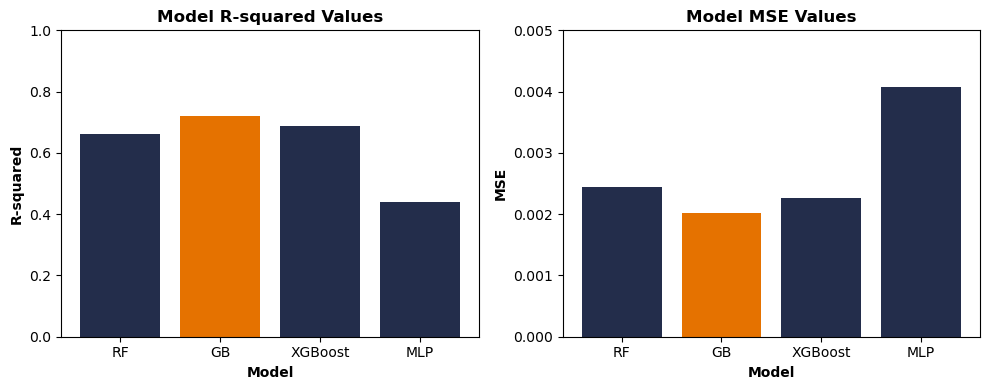

In [13]:
# Data for R-squared values
r_sqs = [test_r2_rf, test_r2_gb, test_r2_xgb, test_r2_mlp]

# Data for MSE values
MSE_s = [test_mse_rf, test_mse_gb, test_mse_xgb, test_mse_mlp]

# List of model names
model_names = ['RF', 'GB', 'XGBoost', 'MLP']

# Determine colors for R-squared bars
r_sq_colors = ['#E57200' if r == max(r_sqs) else '#232D4B' for r in r_sqs]

# Determine colors for MSE bars
mse_colors = ['#E57200' if mse == min(MSE_s) else '#232D4B' for mse in MSE_s]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the R-squared values
axs[0].bar(model_names, r_sqs, color=r_sq_colors)
axs[0].set_xlabel('Model', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[0].set_ylabel('R-squared', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[0].set_title('Model R-squared Values', fontdict={'fontsize': 12, 'fontweight': 'bold'})
axs[0].tick_params(axis='x', rotation=0)
axs[0].set_ylim(0, 1)

# Plot the MSE values
axs[1].bar(model_names, MSE_s, color=mse_colors)
axs[1].set_xlabel('Model', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[1].set_ylabel('MSE', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[1].set_title('Model MSE Values', fontdict={'fontsize': 12, 'fontweight': 'bold'})
axs[1].tick_params(axis='x', rotation=0)
axs[1].set_ylim(0, 0.005)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
import joblib

# Save the best model
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

['best_xgb_model.pkl']